#**HOMEWORK 2: REAL ESTATE PRICE PREDICTION (Total: / 25 points)**

# *Names: (Student One, Student Two)*

Make sure that you answer the two conceptual questions provided at the front of the notebook (edit the XXX response sections to provide your answers). You probably want to answer these last, after you finish the hands-on portion of the assignment. 

#*Background: Use Case*

Your task here is to use the supplied dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Your customers are individual sellers, buyers, and real estate agent, who wishes to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

#**Answers to Written Questions (2 points)**

**Question 1: Why is it necessaty to resize the images? What impact, conceptually, would the choice of image size have on the prediction task, computationally / practically, but also in terms of prediction performnace (note: I'm not asking you try out different sizes to see what happens; I'm asking you to think about 'why' a choice of a smaller vs. larger image resizing would matter.)**

Resizing the images is necessary, in order to ensure a fixed shape for the input features the network receives for any given observation. Conceptually, resizing the images to be smaller means there is less data involved, so the network has fewer parameters to fit, and its 'faster'; however, it also means we are throwing away information, so prediction may become more difficult. 

**Question 2: Are there any predictors that you decided to discard here (numeric or image-based)? Why or why not; what did you consider when making these choices? Did you add any features? What, and why?**

Zipcode is the most questionable feature to deal with here. If you keep zipcode as a one-hot encoding, you need to think about how you would handle a prediction for a new home, in a new zipcode, after training the model on the historical data, were that zipcode not present. There are at least three ways you could reasonably deal with this. First, you might drop zipcode as a predictor (this is probably throwing out a lot of useful information on home prices though). Second, you could one-hot encode them, but allow for new zipcodes to enter, e.g., construct dummies for all 42,000+ zipcodes in the USA, given they are fixed and knowable; or create an 'unknown' dummy. The third, best thing, is to look up characteristics of the zip code, and use those predictors. Anything technically goes here, including median home prices, population densities, etc. Those would all be available pieces of information for a prediction! I retained all images, as there isn't a great rationale for removing any of them from the sample. 

#**Importing the Data**

I've provided some starter code for importing the data...

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Mounted at /content/drive
The shape of our kitchen image array is (535, 200, 200, 3)


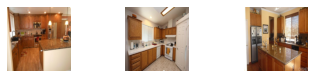

In [ ]:
try:
  from uszipcode import SearchEngine
except ImportError as error:
  !pip install uszipcode
  from uszipcode import SearchEngine

import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image

drive.mount('/content/drive', force_remount=True)

# Replace with your basepath in your Google Drive
basePath = 'drive/MyDrive/Teaching/Courses/BA 865/Pre-Release/Week 5/datasets/Houses Dataset'

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ",header=None,names=cols)

# Pulling out the labels
labels = numericData['price']

# Now removing the label and zipcode from the dataset (because some zipcodes are only represented by one house, for example.)
homeFeatures = numericData.drop(columns=['price','zipcode'])

# Pulling in population density and the fraction of occupied housing units in the zipcode.
sr = SearchEngine()
population_density = []
frac_occupied_housing = []
median_home_price = []
median_income = []
for zip in numericData['zipcode']:
  z = sr.by_zipcode(zip)
  population_density.append(z.population_density)
  houses = z.housing_units
  occ = z.occupied_housing_units
  frac_occupied_housing.append(occ/houses)
  median_home_price = z.median_home_value
  median_income = z.median_household_income

homeFeatures = homeFeatures.assign(pop_dens=population_density,frac_occ=frac_occupied_housing,med_price=median_home_price,income=median_income)

image_size = (200,200)

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 100x100 pictures, with 3 channels (RGB).
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

Shuffle the different arrays, in unison (preserving row ordering across the arrays).

In [ ]:
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_iamge = bedroom_image[shuffled_indices]
homeFeatures = homeFeatures.iloc[shuffled_indices]
labels = labels[shuffled_indices]

#**Create a Multi-Modal NN from Scratch (13 points)**

#*Define Your Model*

Provide your code to implement a multi-modal NN. What we evaluated here... 

*   Did you whiten the numeric data, either using a BatchNorm layer or manually?

*   Does your code run without error?

*   Does your code implement a multi-input NN, with one branch for each image type, and one input branch for the numeric data?  

*   Do your CNN branches follow the standard topology we talked about in class(downsampling to smaller sizes, via pooling, while increasing filter counts). 

*   Do you merge the branches with a Concatenation layer? An Add layer could work too, though reshaping data will be tricky! 

*   Do you produce a single node dense output with an appropriate activation function (linear or ReLU make the most sense)?

*   Do you employ MAE as your loss function? 

*   Did you employ cross-validation? 

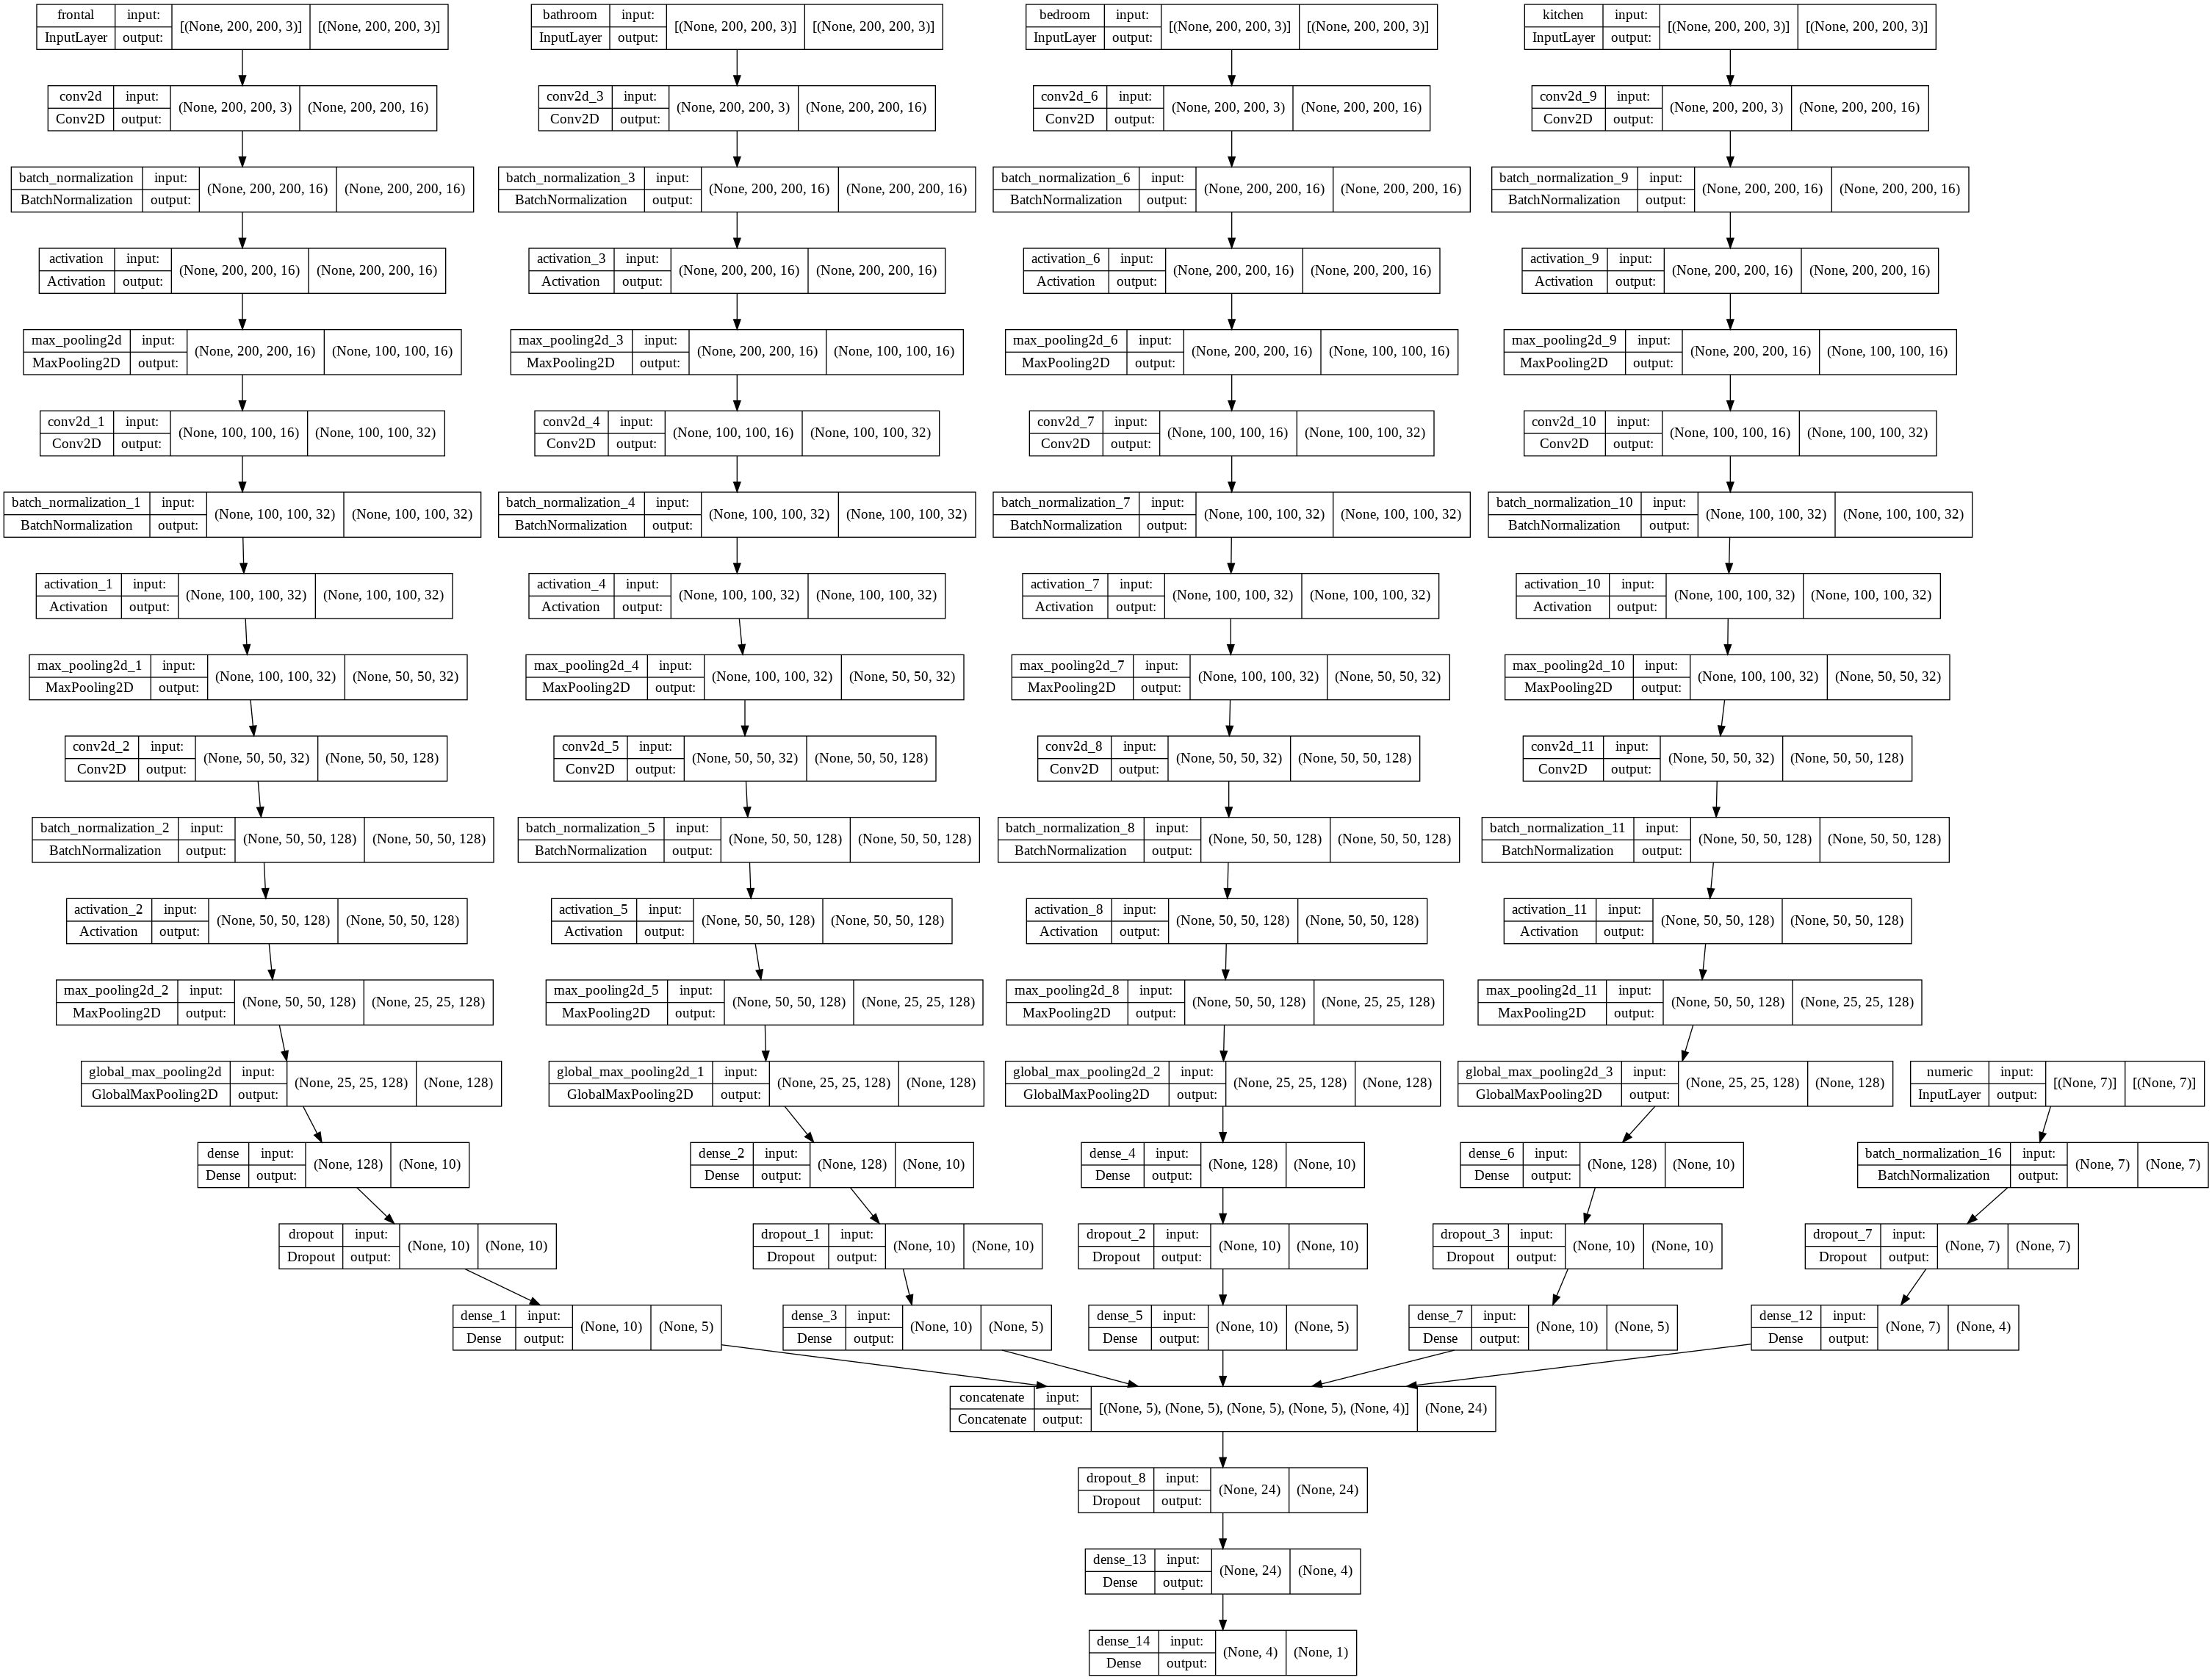

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def create_mlp(name):

    inputs = layers.Input((len(homeFeatures.columns)),name="numeric")
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(50, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(25, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation="relu")(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

def create_cnn(name="generic"):

    inputs = layers.Input((image_size[0],image_size[1],3),name=name)
    x = layers.Conv2D(16, (3,3),padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x) 
    x = layers.Conv2D(32,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(5, activation="relu")(x)
    
    model = keras.Model(inputs, outputs)
    return model

def build_model():
    frontal_model = create_cnn("frontal")
    bathroom_model = create_cnn("bathroom")
    bedroom_model = create_cnn("bedroom")
    kitchen_model = create_cnn("kitchen")
    numeric_model = create_mlp("numeric")

    branch_merge = layers.concatenate([frontal_model.output, bathroom_model.output, bedroom_model.output, kitchen_model.output, numeric_model.output])

    x = layers.Dropout(0.2)(branch_merge)
    x = layers.Dense(4, activation="relu")(x)
    final_output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=[frontal_model.input, bathroom_model.input, bedroom_model.input, kitchen_model.input,numeric_model.input], outputs=final_output)

    model.compile(loss="mae", optimizer="adam")

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

#*Fit Your Model*

Train your model and track validation loss in terms of MAPE. You should define a callback that retains the best performing model across epochs, in terms of validation loss.

Note 1: You needed to apply cross validation here, based on MAE. The sample is much too small to use a simple train-validation split.

In [ ]:
train_data = [front_image,bathroom_image,bedroom_image,kitchen_image,homeFeatures]

k = 5
num_val_samples = len(train_data[0]) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 20
batch_size = 5

all_train_mae_histories = []  
all_val_mae_histories = []
for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    #val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data = [item[i*num_val_samples: (i+1) * num_val_samples] for item in train_data]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data = []
    for item in train_data:
      partial_train_data.append(np.concatenate([item[:i * num_val_samples],item[(i + 1) * num_val_samples:]],axis=0))
       
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_val_history = history.history['val_loss']
    mae_train_history = history.history['loss']
    all_val_mae_histories.append(mae_val_history)
    all_train_mae_histories.append(mae_train_history)

average_mae_train_history = [np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]
average_mae_val_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Epoch 1/20
86/86 [==============================] - 14s 33ms/step - loss: 597118.1875 - val_loss: 528549.5625
Epoch 2/20
86/86 [==============================] - 2s 25ms/step - loss: 588517.6875 - val_loss: 516277.3125
Epoch 3/20
86/86 [==============================] - 2s 25ms/step - loss: 525585.2500 - val_loss: 492216.0625
Epoch 4/20
86/86 [==============================] - 2s 26ms/step - loss: 417196.0312 - val_loss: 418200.9688
Epoch 5/20
86/86 [==============================] - 2s 25ms/step - loss: 347035.5625 - val_loss: 318262.0938
Epoch 6/20
86/86 [==============================] - 2s 25ms/step - loss: 358254.8750 - val_loss: 296778.5000
Epoch 7/20
86/86 [==============================] - 2s 25ms/step - loss: 336362.6250 - val_loss: 287824.2500
Epoch 8/20
86/86 [==============================] - 2

Plot your model's loss over epochs to undertand its performance. It appears that my model tops out around 7-8 epochs but it does not overfit. The MAE ends up around $340,000.

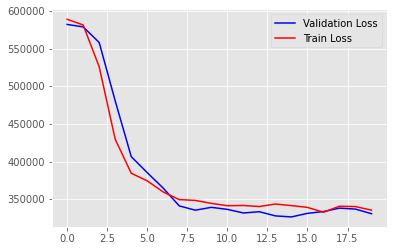

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Fill this in.
plt.plot(average_mae_val_history,c="b")
plt.plot(average_mae_train_history,c="r")
plt.legend(['Validation Loss','Train Loss'])
plt.show()

#**Now Use a Pre-Trained Model (10 points)**

In this section, you should replace the CNN components of your 'from-scratch' network with a pre-trained model. You can use VGG16 (or another model) to pre-process your images into numeric vectors, and then feed those vectors into a standard, dense feed-forward NN to generate predictions. I'm using a version of ResNet here.

Grading points...

*  Does your model / code fit without error? 

*  Did you pre-process your images through the convolutional base layers of a pre-trained model? Or, did you load the layers of a pre-trained model and 'freeze' them, to build atop of? 

*  How did you transition from the Conv2D output of the pre-trained model into your dense layers? You should have used GlobalMaxPooling2D. Simply flattening those layers is not a great idea, because it means you are mixing the feature maps' elements together in a vector, which will be hard for your model to work with.

*  Did you maintain the branch structure as before (separate inputs for each image type and the numeric data?

*  Did you merge the branches together via a concatenate or add layer? 

*  Did you cross-validate?

#*Load Pre-Trained Model's CNN layers*

In [ ]:
conv_base_ResNetV2 = keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size[0],image_size[1], 3)
)

#conv_base_ResNetV2.summary()

#*Pre-process Your Images Through the Pre-trained Model's CNN Layers*

You need to write a quick function that loops over your images and runs them through the pre-trained CNN layers to get back the numeric vector representations.

In [ ]:
def get_ResNet_representations(dataset):
    all_batch_vector_reps = []
    preprocessed_images = keras.applications.resnet_v2.preprocess_input(dataset)
    batch_vector_rep = conv_base_ResNetV2.predict(preprocessed_images)
    all_batch_vector_reps.append(batch_vector_rep)
    return np.concatenate(all_batch_vector_reps)
  
front_image_ResNet = get_ResNet_representations(front_image)
bedroom_image_ResNet =  get_ResNet_representations(bedroom_image)
bathroom_image_ResNet =  get_ResNet_representations(bathroom_image)
kitchen_image_ResNet =  get_ResNet_representations(kitchen_image)

# These are 2048, 7x7 dimensional feature maps - you can pass them into a GlobalMaxPooling2D layer.
print(front_image_ResNet.shape)

# Recall we already created labels and homeFeatures data earlier, which are still numpy arrays in memory.
print(homeFeatures.shape)
print(labels.shape)

(535, 7, 7, 2048)
(535, 7)
(535,)


#*Define Your Dense Network*

You will once again have a multi-branch network, but you've no longer any need for CNNs here. Just use a couple of Dense layers, merge the branches together and then produce a numeric prediction.

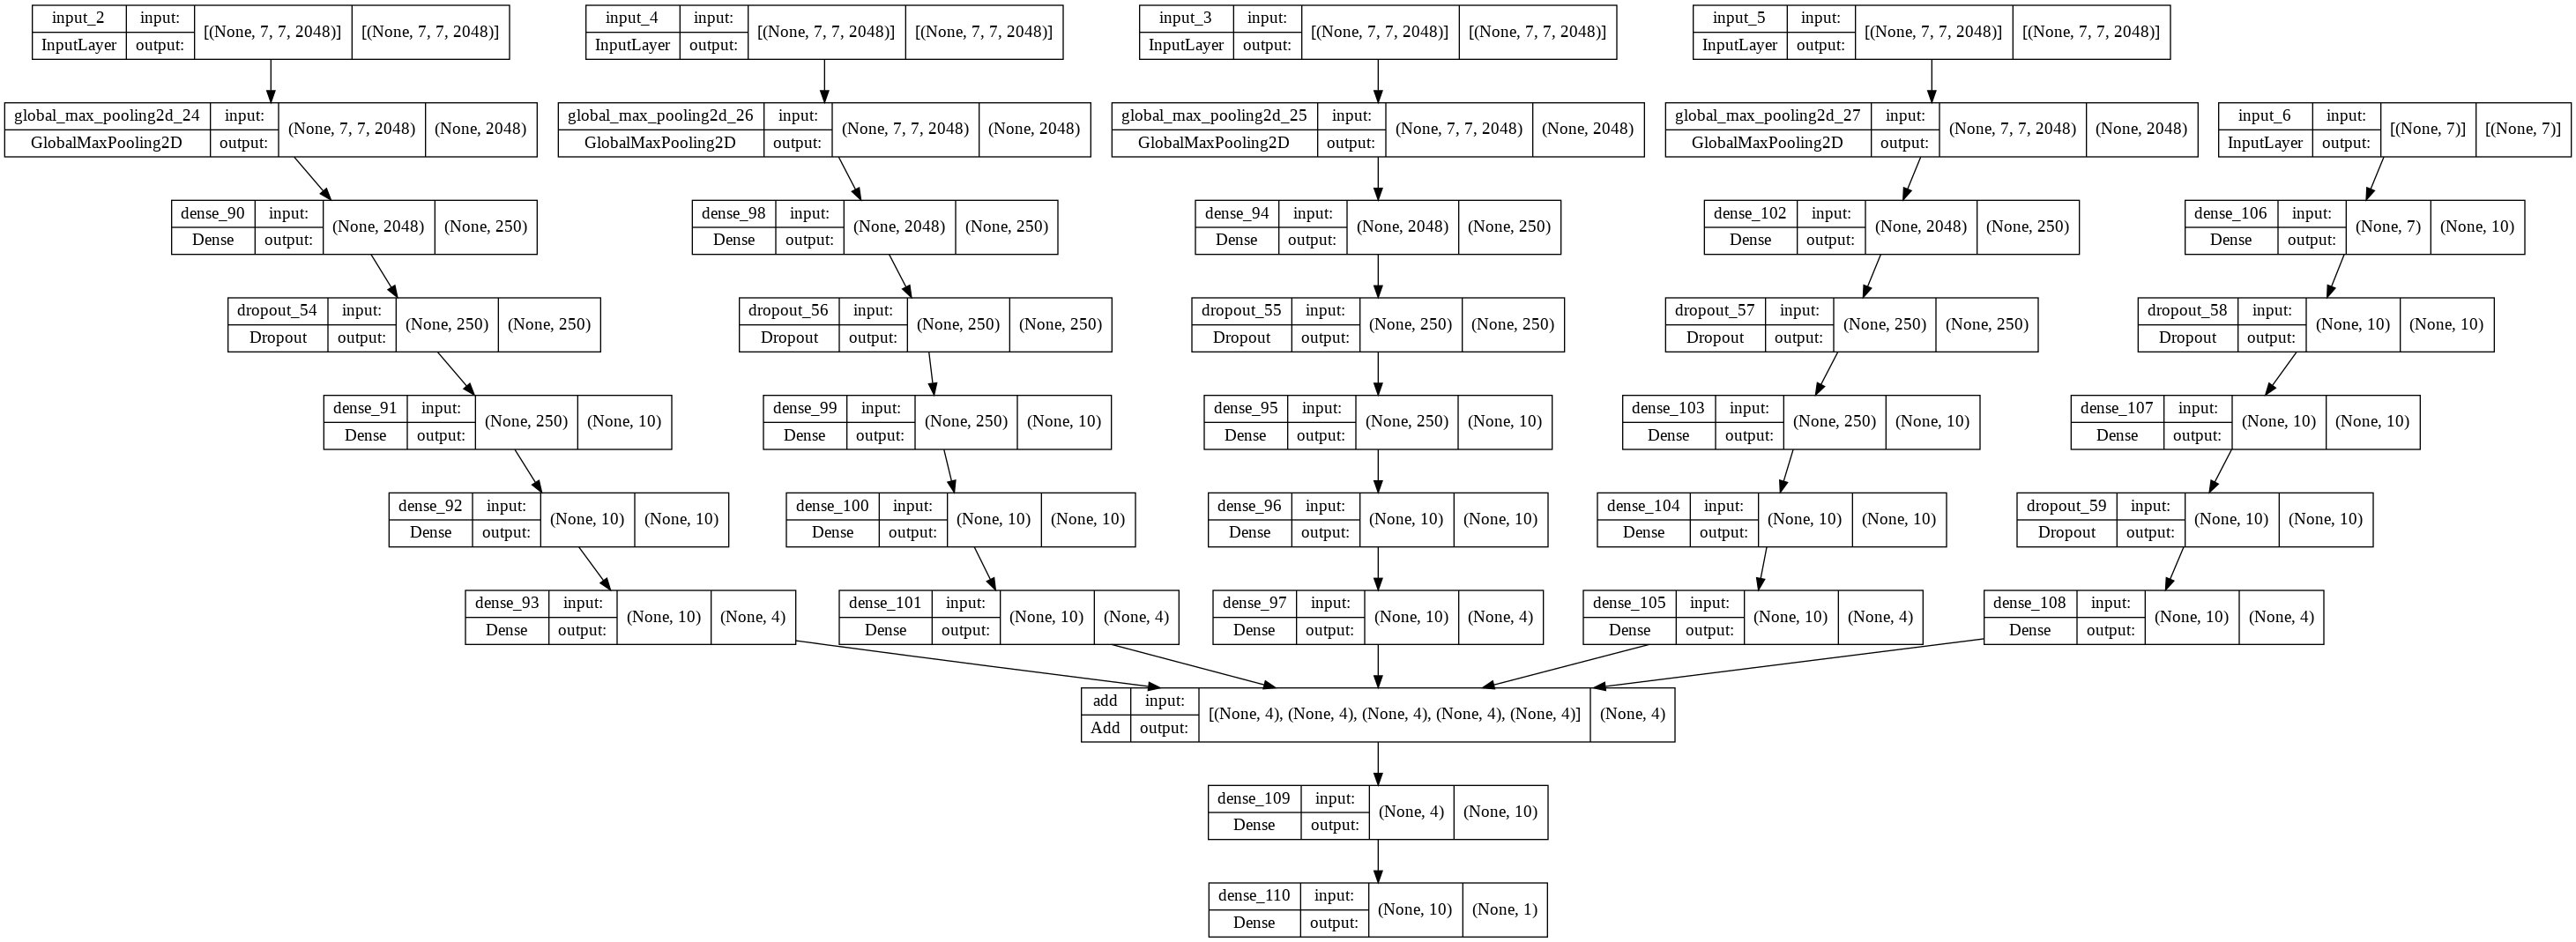

In [ ]:
dropout_rate = 0.3
layer_args = {
    #'kernel_regularizer':'l2',
    'activation':'relu'   
}

def build_model_ResNet():

    front_inputs = layers.Input(front_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(front_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    front_outputs = layers.Dense(4, **layer_args)(x)

    bedroom_inputs = layers.Input(bedroom_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(bedroom_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    bedroom_outputs = layers.Dense(4, **layer_args)(x)

    bathroom_inputs = layers.Input(bathroom_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(bathroom_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    bathroom_outputs = layers.Dense(4, **layer_args)(x)

    kitchen_inputs = layers.Input(kitchen_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(kitchen_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    kitchen_outputs = layers.Dense(4, **layer_args)(x)

    numeric_inputs = layers.Input(homeFeatures.shape[1:])
    x = layers.Dense(10, **layer_args)(numeric_inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    numeric_outputs = layers.Dense(4, **layer_args)(x)

    # I use an Add() here, but you could also try a Concatenate layer.
    branch_merge = layers.Add()([front_outputs, bathroom_outputs, bedroom_outputs, kitchen_outputs, numeric_outputs])

    x = layers.Dense(10, **layer_args)(branch_merge)
    final_output = layers.Dense(1)(x)

    model_ResNet = keras.Model(inputs=[front_inputs, bathroom_inputs, bedroom_inputs, kitchen_inputs,numeric_inputs], outputs=final_output)

    model_ResNet.compile(loss="mae", optimizer="adam")

    return model_ResNet

model_res = build_model_ResNet()
keras.utils.plot_model(model_res, show_shapes=True)

#*Next, Fit Your Model*

In [ ]:
num_epochs = 30

pre_train_data = [front_image_ResNet, bedroom_image_ResNet, bathroom_image_ResNet, kitchen_image_ResNet, homeFeatures]

k = 5
num_val_samples = len(pre_train_data[0]) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 50
batch_size = 1

all_val_mae_histories_pre_train = []  
all_train_mae_histories_pre_train = [] 
for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    #val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data = [item[i*num_val_samples: (i+1) * num_val_samples] for item in pre_train_data]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data = []
    for item in pre_train_data:
      partial_train_data.append(np.concatenate([item[:i * num_val_samples],item[(i + 1) * num_val_samples:]],axis=0))
       
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]], axis=0)

    model_pre_train = build_model_ResNet()
    
    history = model_pre_train.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_val_history = history.history['val_loss']
    mae_train_history = history.history['loss']
    all_val_mae_histories_pre_train.append(mae_val_history)
    all_train_mae_histories_pre_train.append(mae_train_history)

average_train_mae_history_pre_train = [np.mean([x[i] for x in all_train_mae_histories_pre_train]) for i in range(num_epochs)]
average_val_mae_history_pre_train = [np.mean([x[i] for x in all_val_mae_histories_pre_train]) for i in range(num_epochs)]

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Epoch 1/50
428/428 [==============================] - 4s 6ms/step - loss: 542660.8750 - val_loss: 284863.9375
Epoch 2/50
428/428 [==============================] - 2s 6ms/step - loss: 326680.5938 - val_loss: 280505.3125
Epoch 3/50
428/428 [==============================] - 3s 6ms/step - loss: 325582.4375 - val_loss: 284628.0625
Epoch 4/50
428/428 [==============================] - 3s 6ms/step - loss: 327216.5938 - val_loss: 283069.0312
Epoch 5/50
428/428 [==============================] - 2s 6ms/step - loss: 325304.9375 - val_loss: 280355.3750
Epoch 6/50
428/428 [==============================] - 2s 6ms/step - loss: 329241.0312 - val_loss: 281146.8125
Epoch 7/50
428/428 [==============================] - 3s 6ms/step - loss: 325192.2500 - val_loss: 280642.1562
Epoch 8/50
428/428 [===========================

Finally, plot your model's validation loss over training. Using the pre-trained model, my MAE falls by about 10%, which is substantial. Still, the error is pretty bad... ~$310k.


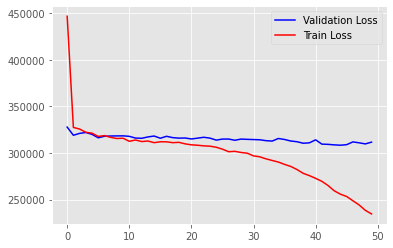

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Fill this in.
plt.plot(average_val_mae_history_pre_train,c="b")
plt.plot(average_train_mae_history_pre_train,c="r")
plt.legend(['Validation Loss','Train Loss'])
plt.show()